# Russian Car Plate Prices
For this project, we will be building a deep learning model to predict russian license plate prices. <br>
Source: https://www.kaggle.com/competitions/russian-car-plates-prices-prediction/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns

from collections import defaultdict

import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from collections import Counter

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

from supplemental_english import REGION_CODES,GOVERNMENT_CODES

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Data Inspection

In [3]:
test.drop(columns=['price'],axis=1,inplace=True)    # Drop response col

In [4]:
print(train.shape,test.shape)

(51635, 4) (7695, 3)


In [5]:
train.dtypes
print(train.head(5))

   id      plate                 date   price
0   1  X059CP797  2024-12-26 00:00:00   65000
1   2  Y800MH790  2024-07-12 21:31:37  100000
2   3   A212TX77  2024-04-18 00:00:00  290000
3   4  P001AY199  2025-01-03 00:27:15  680000
4   5  P001AY199  2025-01-10 09:32:41  750000


We also have 2 dictionaries that correspond to country/government codes. This may influence price. Let's add them to the dataframe.

In [6]:
#   Parse the license plate into components necessary for matching with dictionary
#       - First 3 letters
#       - Following 1-3 digits after that
#       - Last 2-3 digits
def parse_plate(plate):
    match = re.match(r'^([A-ZА-Я])\s*([0-9]{3})\s*([A-ZА-Я]{2})\s*-?\s*([0-9]{2,3})$', plate.strip(), re.IGNORECASE)
    if match:
        series1 = match.group(1).upper()
        number = int(match.group(2))
        series2 = match.group(3).upper()
        region = match.group(4)
        series = series1 + series2
        return series, number, region
    return None, None, None

In [7]:
#   Transform REGION_CODES into more usable format: code:region
code_to_region = {}
for region_name, codes in REGION_CODES.items():
    for code in codes:
        code_to_region[code] = region_name

In [8]:
def gov_plate(plate):
    series,number,region = parse_plate(plate)
    if series is None:
        return None
    for (s,nRange,reg),value in GOVERNMENT_CODES.items():
        if s == series and reg == region and nRange[0] <= number <= nRange[1]:  #   If match
            return value[0]
    return None

def get_reg(plate):
    series, number, region = parse_plate(plate)
    if region is None:
        return None
    return code_to_region.get(region)

train['gov_plate'] = train['plate'].apply(gov_plate)
test['gov_plate'] = test['plate'].apply(gov_plate)
train['region'] = train['plate'].apply(get_reg)
test['region'] = test['plate'].apply(get_reg)

In [9]:
train['region'].value_counts().head()

region
Moscow                  25479
Moscow Oblast           12927
Krasnodar Krai           1417
Saint Petersburg          938
Republic of Dagestan      627
Name: count, dtype: int64

In [10]:
train['gov_plate'].value_counts().head()

gov_plate
Private individuals with connections in the traffic police                                                71
Partially plates of law enforcement in the region (prosecutor's office, EMERCOM, traffic police, etc.)    57
Partially Central Special Communication, Courier Service, Ministry of Communications                      50
Partially plates of Moscow City Duma deputies, police                                                     45
Partially Administration of the President plates                                                          39
Name: count, dtype: int64

In [11]:
print("NA Count")
print(train['gov_plate'].isna().sum()/51635*100,'%')
print(train['region'].isna().sum()/51635*100,'%')

NA Count
98.71792388883509 %
0.0 %


- Plates with government tags only make up 2% of the data. <br>
- Every plate has a region tag

In [12]:
for i in train['plate']:
    if bool(re.search(r'[^a-zA-Z0-9]', i)):
        print(i)

#   All chars are 0-9,a-z

### Tokenize Plates
We will be tokenizing the plates for sequential modeling. <br>
Instead of tokenizing each individual character, we can tokenize groups of characters. For example, abc123 will split to ['abc','123'] then tokenize. <br>
While tokenizing each character is possible, I think it would require the model architecture to be much larger and more complex. <br>
This will pick up on special patterns that may affect price of the plate <br>
i.e. lucky numbers, palindromes, etc.

In [13]:
def tokenize_plate(plate):
    tokens = re.findall(r'[A-Za-z]+|\d+|[^A-Za-z\d]', plate)
    return [token for token in tokens]

#   Creates a dictionary of vocabulary from licenses
def build_vocab(plates):
    vocab = defaultdict(lambda: len(vocab))
    for plate in plates:
        tokens = tokenize_plate(plate)
        for token in tokens:
            _ = vocab[token]
    return dict(vocab)

In [14]:
vocab = build_vocab(train['plate'])
print(len(vocab))

1250


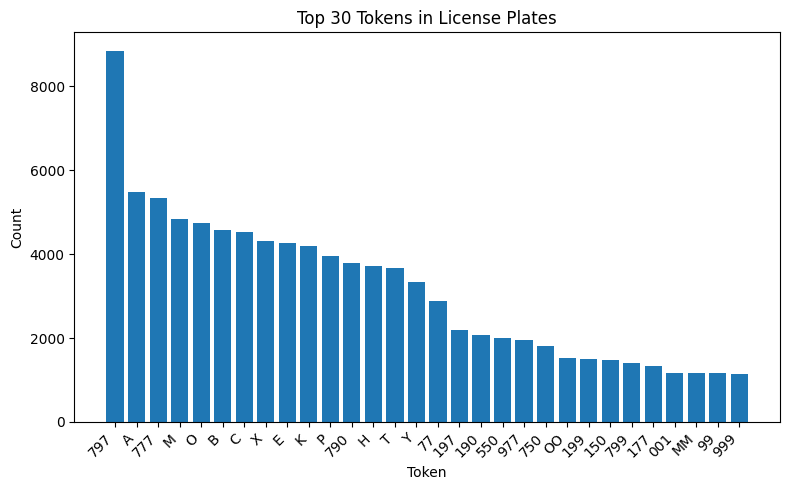

In [15]:
all_tokens = []
for plate in train['plate']:
    all_tokens.extend(tokenize_plate(plate))

token_counts = Counter(all_tokens)
top_words = 30
tokens, counts = zip(*token_counts.most_common(top_words))

plt.figure(figsize=(8, 5))
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')  # tilt x lbls
plt.xlabel('Token')
plt.ylabel('Count')
plt.title(f'Top {top_words} Tokens in License Plates')
plt.tight_layout()
plt.show()



As we can see, there are trends of common characters in these plates. <br>
'797' refers to moscow region. Region/Gov. codes are showing as expected. <br>
'777' is a lucky number. '999','00', etc.

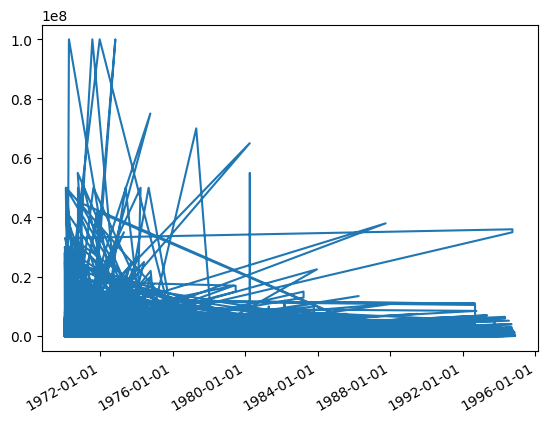

In [16]:
fig, ax = plt.subplots()
ax.plot(train['date'], train['price'])

# Set major locator and formatter
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatic spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Or '%b %d' (Jan 01)

fig.autofmt_xdate()  # Auto-rotate the dates
plt.show()

Maybe a slight correlation between price and date. Seems like plates got cheaper over time, but very messy. <br>
Next, let's look at the response variable.

In [17]:
train

,id,plate,date,price,gov_plate,region
0,1,X059CP797,2024-12-26 00:00:00,65000,None,Moscow
1,2,Y800MH790,2024-07-12 21:31:37,100000,None,Moscow Oblast
2,3,A212TX77,2024-04-18 00:00:00,290000,None,Moscow
3,4,P001AY199,2025-01-03 00:27:15,680000,None,Moscow
4,5,P001AY199,2025-01-10 09:32:41,750000,None,Moscow
...,...,...,...,...,...,...
51630,51631,X023PP797,2025-01-29 00:00:00,70000,None,Moscow
51631,51632,M004KA161,2025-01-31 00:00:00,1600000,None,Rostov Oblast
51632,51633,E888EB199,2025-02-06 00:00:00,850000,None,Moscow
51633,51634,X023XK77,2024-04-24 11:30:07,150000,None,Moscow


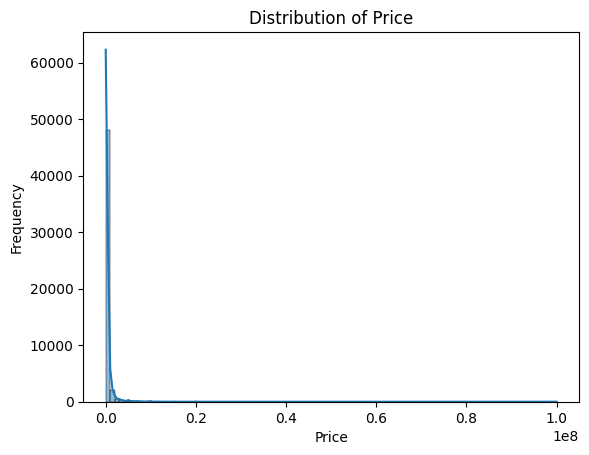

In [18]:
sns.histplot(train['price'], kde=True, bins=100)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Price is Heavily skewed right. Let's try log transforming

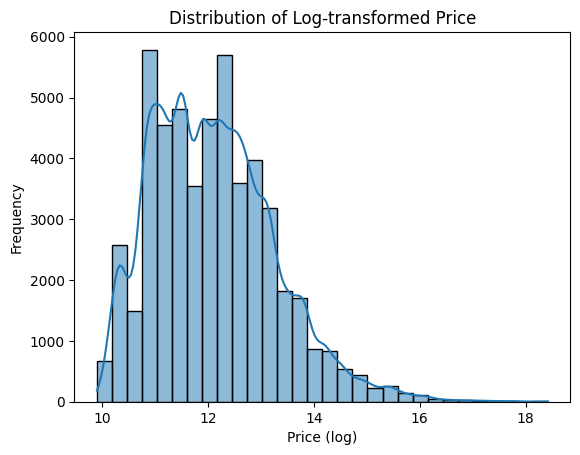

In [19]:
train['price'] = np.log1p(train['price'])

sns.histplot(train['price'], kde=True, bins=30)
plt.title('Distribution of Log-transformed Price')
plt.xlabel('Price (log)')
plt.ylabel('Frequency')
plt.show()

In [20]:
def plate_to_id(plate, vocab):
    return [vocab[token] for token in tokenize_plate(plate)]

train['plate_id'] = train['plate'].apply(lambda x: plate_to_id(x,vocab))
test['plate_id'] = test['plate'].apply(lambda x: plate_to_id(x,vocab))

Now we can drop 'plate' column.

In [21]:
train.drop(columns=['plate'],axis=1,inplace=True)
test.drop(columns=['plate'],axis=1,inplace=True)

### Finish up preprocessing
Encode region and gov_plate <br>
Transform date into a more valuable metric

In [22]:
# Combine train and test
all_regions = pd.concat([train['region'], test['region']])
all_gov_plates = pd.concat([train['gov_plate'], test['gov_plate']])

# Fit on all data and transform
reg_enc = LabelEncoder()
reg_enc.fit(all_regions)
train['region'] = reg_enc.transform(train['region'])
test['region'] = reg_enc.transform(test['region'])

gov_enc = LabelEncoder()
gov_enc.fit(all_gov_plates)
train['gov_plate'] = gov_enc.transform(train['gov_plate'])
test['gov_plate'] = gov_enc.transform(test['gov_plate'])


To handle the dates of purchase, I believe a valuable format would just make a column for year and column for month.

In [23]:
def change_date(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop(columns=['date'],axis=1,inplace=True)

    return df

train = change_date(train)
test = change_date(test)

#   Drop id for train set
train.drop(columns=['id'],axis=1,inplace=True)

In [24]:
#   T/T Split
train, val = train_test_split(train, test_size=0.2, random_state=68)

In [25]:
train.head(5)

,price,gov_plate,region,plate_id,year,month
43115,13.262127,60,73,"[75, 62, 35, 62]",2024,4
35987,10.819798,60,36,"[37, 142, 361, 7]",2024,12
48961,11.695255,60,50,"[0, 264, 145, 686]",2024,1
38681,12.429220,60,35,"[52, 331, 127, 84]",2024,10
44610,12.506181,60,35,"[12, 203, 149, 11]",2023,9


## Model Architecture
Initially, my intentions were to utilize a recurrent neural network as the sequential order of the plates may be important. <br>
Now we have a tokenized version of the plate which clusters groups of characters (123abc -> [123],[abc]) <br>
We will test the hypothesis of whether or not sequential order is still valuable. <br><br>

####    First Run: RNN Model for Sequential Plate Tokens


In [26]:
#   Symmetric Mean Absolute Percentage Error (SMAPE) for Scoring (as in kaggle comp)
def smape(y_true, y_pred):
    numerator = tf.abs(y_true - y_pred)
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + 1e-8  # avoid division by zero
    return tf.reduce_mean(numerator / denominator)

In [27]:
max_seq_len = 4
num_plate_tokens = len(vocab)    # size of your plate_id vocabulary
num_region_cats = max(train['region'].max(), val['region'].max(), test['region'].max()) + 1    # number of unique region values
num_gov_cats = max(train['gov_plate'].max(), val['gov_plate'].max(), test['gov_plate'].max()) + 1

plate_in = Input(shape=(max_seq_len,),name='plate_id')
plate_embed = Embedding(input_dim = num_plate_tokens,output_dim = 16)(plate_in)    #   mask_zero -> ignore embedding
plate_seq = GRU(16)(plate_embed)

region_in = Input(shape=(1,), name = 'region')
region_embed = Embedding(input_dim=num_region_cats, output_dim = 4)(region_in)
region_flat = Flatten()(region_embed)   #   Flatten

gov_in = Input(shape=(1,), name='gov_plate')
gov_embed = Embedding(input_dim = num_gov_cats, output_dim = 4)(gov_in)
gov_flat = Flatten()(gov_embed)

year_in = Input(shape=(1,), name = 'year')
month_in = Input(shape=(1,), name = 'month')

feats = Concatenate()([plate_seq, region_flat, gov_flat, year_in, month_in])

x = Dense(64, activation = 'relu')(feats)
x = Dense(32, activation = 'relu')(x)
output = Dense(1, activation = 'linear')(x)

In [28]:
model = Model(inputs=[plate_in, region_in, gov_in, year_in, month_in], outputs = output)
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[smape]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 plate_id (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 region (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 gov_plate (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 4, 16)                20000     ['plate_id[0][0]']            
                                                                                              

In [29]:
# Convert to numpy arrays
X_plate_train = np.array(train['plate_id'].tolist())
X_plate_val = np.array(val['plate_id'].tolist())

X_region_train = train['region'].to_numpy()
X_region_val = val['region'].to_numpy()

X_gov_train = train['gov_plate'].to_numpy()
X_gov_val = val['gov_plate'].to_numpy()

X_year_train = train['year'].to_numpy()
X_year_val = val['year'].to_numpy()

X_month_train = train['month'].to_numpy()
X_month_val = val['month'].to_numpy()

y_train = train['price'].to_numpy()
y_val = val['price'].to_numpy()


In [30]:
history = model.fit(
    [X_plate_train, X_region_train, X_gov_train, X_year_train, X_month_train],
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(
        [X_plate_val, X_region_val, X_gov_val, X_year_val, X_month_val],
        y_val
    )
)

print("Final Train Loss:", history.history['loss'][-1])
print("Final Val Loss:", history.history['val_loss'][-1])

Epoch 1/20
323/323 [==============================] - 3s 3ms/step - loss: 3685.5667 - smape: 0.3656 - val_loss: 1.4727 - val_smape: 0.0799
Epoch 2/20
323/323 [==============================] - 1s 2ms/step - loss: 1.5047 - smape: 0.0802 - val_loss: 1.4544 - val_smape: 0.0794
Epoch 3/20
323/323 [==============================] - 1s 2ms/step - loss: 1.4814 - smape: 0.0796 - val_loss: 1.4255 - val_smape: 0.0789
Epoch 4/20
323/323 [==============================] - 1s 2ms/step - loss: 1.4153 - smape: 0.0777 - val_loss: 1.2738 - val_smape: 0.0741
Epoch 5/20
323/323 [==============================] - 1s 2ms/step - loss: 0.9174 - smape: 0.0604 - val_loss: 0.6949 - val_smape: 0.0526
Epoch 6/20
323/323 [==============================] - 1s 2ms/step - loss: 0.6801 - smape: 0.0517 - val_loss: 0.6561 - val_smape: 0.0511
Epoch 7/20
323/323 [==============================] - 1s 2ms/step - loss: 0.6427 - smape: 0.0500 - val_loss: 0.6311 - val_smape: 0.0497
Epoch 8/20
323/323 [=========================

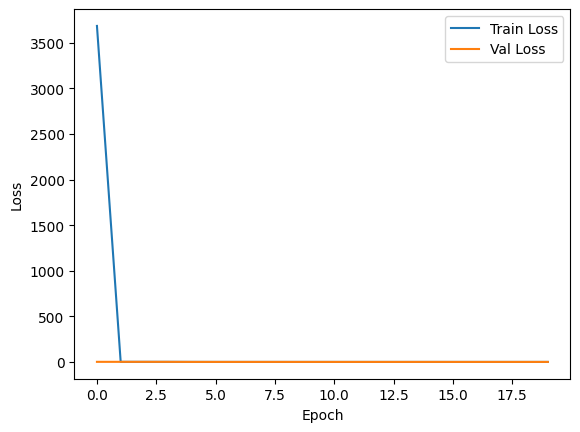

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
X_plate = np.array(val['plate_id'].tolist())
X_region = val['region'].to_numpy()
X_gov = val['gov_plate'].to_numpy()
X_year = val['year'].to_numpy()
X_month = val['month'].to_numpy()
y = val['price'].to_numpy()

val_loss, val_smape = model.evaluate(
    [X_plate, X_region, X_gov, X_year, X_month],
    y
)
print("Validation Loss:", val_loss)
print("Validation SMAPE:", val_smape)

323/323 [==============================] - 0s 1ms/step - loss: 0.5391 - smape: 0.0455
Validation Loss: 0.5390603542327881
Validation SMAPE: 0.04549067094922066


#### Tweaking LR
Previous iteration was done with LR = 0.001. Because of the instability in validation loss, let's try decreasing it.

Epoch 1/20
323/323 [==============================] - 3s 3ms/step - loss: 830.3520 - smape: 0.2436 - val_loss: 0.8254 - val_smape: 0.0576
Epoch 2/20
323/323 [==============================] - 1s 2ms/step - loss: 0.6549 - smape: 0.0502 - val_loss: 0.5683 - val_smape: 0.0461
Epoch 3/20
323/323 [==============================] - 1s 2ms/step - loss: 0.5337 - smape: 0.0444 - val_loss: 0.5370 - val_smape: 0.0446
Epoch 4/20
323/323 [==============================] - 1s 3ms/step - loss: 8.9463 - smape: 0.1194 - val_loss: 0.5792 - val_smape: 0.0464
Epoch 5/20
323/323 [==============================] - 1s 3ms/step - loss: 0.5288 - smape: 0.0442 - val_loss: 0.5452 - val_smape: 0.0446
Epoch 6/20
323/323 [==============================] - 1s 3ms/step - loss: 0.5049 - smape: 0.0430 - val_loss: 0.5238 - val_smape: 0.0438
Epoch 7/20
323/323 [==============================] - 1s 3ms/step - loss: 0.4901 - smape: 0.0424 - val_loss: 0.5240 - val_smape: 0.0443
Epoch 8/20
323/323 [==========================

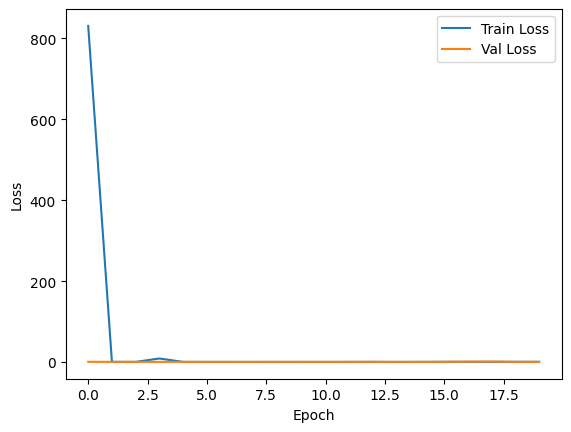

323/323 [==============================] - 0s 883us/step - loss: 0.5777 - smape: 0.0465
Validation Loss: 0.5777217745780945
Validation SMAPE: 0.04652045667171478
Epoch 1/20
323/323 [==============================] - 3s 3ms/step - loss: 0.3657 - smape: 0.0370 - val_loss: 0.5047 - val_smape: 0.0427
Epoch 2/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3567 - smape: 0.0364 - val_loss: 0.5043 - val_smape: 0.0429
Epoch 3/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3582 - smape: 0.0365 - val_loss: 0.5200 - val_smape: 0.0435
Epoch 4/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3545 - smape: 0.0363 - val_loss: 0.5089 - val_smape: 0.0430
Epoch 5/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3496 - smape: 0.0361 - val_loss: 0.4997 - val_smape: 0.0424
Epoch 6/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3462 - smape: 0.0358 - val_loss: 0.4999 - val_smape: 0.0425
Epoch 7/20
323/323 [==

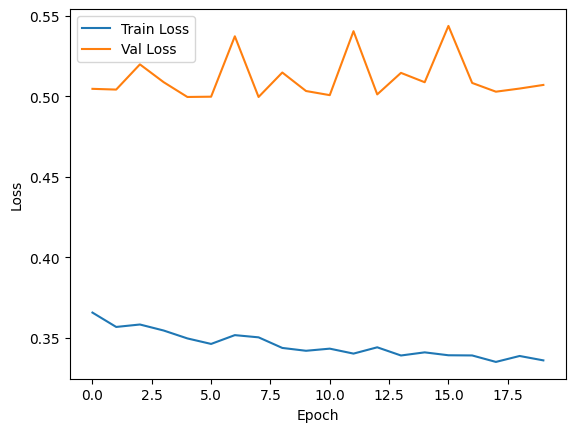

323/323 [==============================] - 0s 777us/step - loss: 0.5072 - smape: 0.0429
Validation Loss: 0.5071750283241272
Validation SMAPE: 0.04287310317158699
Epoch 1/20
323/323 [==============================] - 2s 3ms/step - loss: 0.4290 - smape: 0.0392 - val_loss: 0.5023 - val_smape: 0.0426
Epoch 2/20
323/323 [==============================] - 1s 2ms/step - loss: 0.3466 - smape: 0.0360 - val_loss: 0.5104 - val_smape: 0.0431
Epoch 3/20
323/323 [==============================] - 1s 2ms/step - loss: 0.3582 - smape: 0.0367 - val_loss: 0.5061 - val_smape: 0.0428
Epoch 4/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3471 - smape: 0.0360 - val_loss: 0.5319 - val_smape: 0.0445
Epoch 5/20
323/323 [==============================] - 1s 3ms/step - loss: 0.3493 - smape: 0.0362 - val_loss: 0.5097 - val_smape: 0.0428
Epoch 6/20
323/323 [==============================] - 1s 2ms/step - loss: 0.3426 - smape: 0.0358 - val_loss: 0.5147 - val_smape: 0.0434
Epoch 7/20
323/323 [==

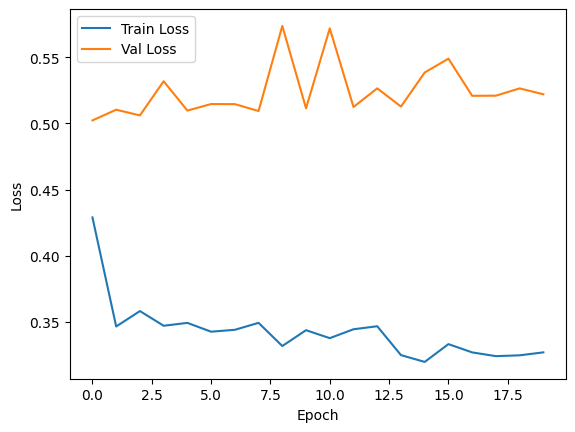

323/323 [==============================] - 0s 816us/step - loss: 0.5220 - smape: 0.0433
Validation Loss: 0.5220438838005066
Validation SMAPE: 0.043293461203575134


In [33]:
for i in [0.01,0.0001,0.0005]:
    model2 = Model(inputs=[plate_in, region_in, gov_in, year_in, month_in], outputs = output)
    optimizer = Adam(learning_rate=i)
    model2.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[smape]
    )

    history = model2.fit(
        [X_plate_train, X_region_train, X_gov_train, X_year_train, X_month_train],
        y_train,
        batch_size=128,
        epochs=20,
        validation_data=(
            [X_plate_val, X_region_val, X_gov_val, X_year_val, X_month_val],
            y_val
        )
    )

    print("Final Train Loss:", history.history['loss'][-1])
    print("Final Val Loss:", history.history['val_loss'][-1])

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    val_loss, val_smape = model2.evaluate(
        [X_plate, X_region, X_gov, X_year, X_month],
        y
    )
    print("Validation Loss:", val_loss)
    print("Validation SMAPE:", val_smape)


### Learning Rate is not an issue alone.
Change in learning rate just introduces more issues. <br>
Therefore, the previous iteration is the best. <br>
Because it performs so highly, it is reasonable to conclude that this model is the best approach.

### Kaggle Upload

In [40]:
X_plate_test = np.array(test['plate_id'].tolist())
X_region_test = np.array(test['region'].tolist())
X_gov_test = np.array(test['gov_plate'].tolist())
X_year_test = np.array(test['year'].tolist())
X_month_test = np.array(test['month'].tolist())

y_pred = model.predict([X_plate_test, X_region_test, X_gov_test, X_year_test, X_month_test])


241/241 [==============================] - 0s 1ms/step


In [41]:
y_pred_unlogged = np.expm1(y_pred)
print(y_pred_unlogged)
y_pred_unlogged = y_pred_unlogged.flatten()


[[ 206720.97 ]
 [  41956.402]
 [ 350163.75 ]
 ...
 [ 276974.66 ]
 [2006438.5  ]
 [ 476198.06 ]]


In [43]:
submission = pd.DataFrame({
    'id': test['id'],
    'price': y_pred_unlogged
})

submission.to_csv('sub.csv',index=False)